In [2]:
library(data.table)
library(Rmisc)
library(ggplot2)
library(dplyr)
library(reshape2)
library(bit)
library(zoo)

## Data Preperation

### 1. Read raw data (i.e., reviews)

In [3]:
rws=fread("../data/rws.all.csv")

### 2. Read facial attributes for both hosts and guests and merge those attributes with the review data

In [4]:
guest=fread("../data/guest.attribute.csv")
colnames(guest)[c(8)]=c("g.ethnicity")
guest=guest[,c("guest_id","g.ethnicity")]
rws.gh=left_join(rws,guest, by="guest_id",type='left')

In [5]:
#-Note that h.num_face==0 represents hots without any human face in their profile photos.
#-In this case, h.ethnicity is empty string.
#-Additional filtering is required depending on analysis,
#-since profile photos with more than 1 human face also have empty string in the h.ethnicity column.
host=fread("../data/host.attribute.csv")
colnames(host)[c(5,8)]=c("h.num_face","h.ethnicity")
host=host[,c("listing_id","host_id","h.num_face","h.ethnicity")]
rws.gh=left_join(rws.gh,host, by=c("listing_id","host_id"))

In [6]:
#-Remove those racially unidentified guests
rws.gh=rws.gh[rws.gh$g.ethnicity!="",]

In [7]:
#-Label RA for racially ambiguous hosts
rws.gh$h.ethnicity=ifelse(rws.gh$h.num_face==0, "RA", rws.gh$h.ethnicity)

In [8]:
#-Remove those racially unidentified hosts (with multiple human faces in their profile photos)
rws.gh=rws.gh[rws.gh$h.ethnicity!="",]

### 3. Create booking- / staying-level reputation and endorsement signals

#### 3.1. Create columns for # of previous reviews and race of previous reviewers for each booking/staying

In [9]:
df=rws.gh

In [10]:
df=df %>% group_by(listing_id) %>% arrange(date) %>%
  mutate(cum.cnt=row_number()-1,
         rws.race=lag(g.ethnicity, n = 1, default = NA))

#### 3.2. Count the previous guest race for each booking

In [11]:
#-Create column and add counter
df$g.W.cnt=ifelse(df$rws.race=="WHITE", 1, 0)
df$g.B.cnt=ifelse(df$rws.race=="BLACK", 1, 0)
df$g.A.cnt=ifelse(df$rws.race=="ASIAN", 1, 0)

In [12]:
#-Sort reviews for each listing by date
#-Then roll sum racial compositions in the most recent 6 reviews for each booking
#-Note that the most 6 reviews are the proxy of front-page reviews
df = df %>% group_by(listing_id) %>% arrange(date) %>%
    mutate(top6.W=rollsumr(g.W.cnt==1, 6, fill=NA),
           top6.B=rollsumr(g.B.cnt==1, 6, fill=NA),
           top6.A=rollsumr(g.A.cnt==1, 6, fill=NA))

In [13]:
#-Code the first review's the most recent previous reviewer's race as 0
#-and then count all the previous reviewers' races cumulatively
df$rws.race[which(is.na(df$rws.race))]=0

df = df %>% group_by(listing_id) %>% arrange(date) %>% 
    mutate(g.W.cnt=cumsum(rws.race=="WHITE"),
           g.B.cnt=cumsum(rws.race=="BLACK"),
           g.A.cnt=cumsum(rws.race=="ASIAN"))

In [14]:
df=as.data.table(df)

In [15]:
#-Extract only listings that allow instant booking
df=df[which(df$instant_bookable=="t"),]

# ----------------------------------------------------------------------------------------

## Pairing probabilities between non-racially-identified hosts and guests with a racial identy conditional on same-race reviews

- Fig. 2
- No-human-face & no-person-name
- No-human-face & no-person-name + racially-unidentifiable-person-name
- No-human-face
- Sinc above conditions using a named-entity recognition still show the identical results, we report the results with no photos and photos with no human faces as racially unidentified users!

### 1. Compute paring probabilities across different race combinations

#### 1.1. Extract only relevant columns and create counterfactuals

In [16]:
create_ctf_1 = function(df.x) {
    df.tmp.ctf=df.x
    df.tmp.ctf$pairing.status=0
    df.tmp.ctf$g.ethnicity=ifelse(df.tmp.ctf$g.ethnicity=="BLACK" |
                                  df.tmp.ctf$g.ethnicity=="ASIAN",
                                  "WHITE", "BLACK")
    return(df.tmp.ctf)
}

create_ctf_2 = function(df.x) {
    df.tmp.ctf=df.x
    df.tmp.ctf$pairing.status=0
    df.tmp.ctf$g.ethnicity=ifelse(df.tmp.ctf$g.ethnicity=="BLACK" |
                                  df.tmp.ctf$g.ethnicity=="WHITE",
                                  "ASIAN", "BLACK")
    return(df.tmp.ctf)
}

create_ctf = function(df.x) {
    return(rbind(create_ctf_1(df.x),create_ctf_2(df.x)))
}

In [17]:
df.tmp.obs=df[, c("h.ethnicity", "g.ethnicity",
                  "top6.A", "top6.B", "top6.W"), with=FALSE]
df.tmp.obs$pairing.status=1

In [18]:
#-Cap to 5 due to small N for Asian and Black guests on SRE 5 and 6
df.tmp.obs$top6.A=ifelse(df.tmp.obs$top6.A>5, 5, df.tmp.obs$top6.A)
df.tmp.obs$top6.B=ifelse(df.tmp.obs$top6.B>5, 5, df.tmp.obs$top6.B)
df.tmp.obs$top6.W=ifelse(df.tmp.obs$top6.W>5, 5, df.tmp.obs$top6.W)
df.tmp.obs

h.ethnicity,g.ethnicity,top6.A,top6.B,top6.W,pairing.status
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
BLACK,WHITE,NA,NA,NA,1
BLACK,WHITE,NA,NA,NA,1
BLACK,WHITE,NA,NA,NA,1
BLACK,ASIAN,NA,NA,NA,1
BLACK,WHITE,NA,NA,NA,1
BLACK,WHITE,NA,NA,NA,1
BLACK,WHITE,1,0,5,1
BLACK,WHITE,1,0,5,1
WHITE,WHITE,NA,NA,NA,1


In [19]:
df.tmp.ctf=create_ctf(df.tmp.obs)

#### 1.2. Combine counterfactuals with observations and compute average pairing probabilities 

In [20]:
df.obs.ctf=rbind(df.tmp.obs,df.tmp.ctf)

In [21]:
df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="WHITE"]=df.obs.ctf$top6.W[df.obs.ctf$g.ethnicity=="WHITE"]
df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="ASIAN"]=df.obs.ctf$top6.A[df.obs.ctf$g.ethnicity=="ASIAN"]
df.obs.ctf$sre[df.obs.ctf$g.ethnicity=="BLACK"]=df.obs.ctf$top6.B[df.obs.ctf$g.ethnicity=="BLACK"]

In [22]:
df.obs.ctf=df.obs.ctf[complete.cases(df.obs.ctf), ]

In [23]:
summary.pairing.prob.obs=summarySE(df.obs.ctf, measurevar="pairing.status",
                                   groupvars=c("h.ethnicity",
                                               "g.ethnicity",
                                               "sre"))

### 2. Compute the pairing probabilities compared to the random baseline and plot the results

#### 2.1. Create n random baselines (for standard errors) and compute the difference with the observations

In [24]:
df.tmp.rnd=df.tmp.obs

In [25]:
#-Permutate g.ethnicity for n times to create a random baseline
#-to compare the difference between obeservations and random chances
#-as well as to create standard errors... .

start_time=Sys.time()

shuffle_time=1000
l_rand=list()
l_diff=list()
for(x in 1:shuffle_time){
    df.tmp=df.tmp.rnd
    df.tmp$g.ethnicity=df.tmp.rnd[sample(nrow(df.tmp.rnd)),]$g.ethnicity
    
    df.tmp.ctf=create_ctf(df.tmp)
    df.tmp.rnd.ctf=rbind(df.tmp,df.tmp.ctf)
    
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="WHITE"]=df.tmp.rnd.ctf$top6.W[df.tmp.rnd.ctf$g.ethnicity=="WHITE"]
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="ASIAN"]=df.tmp.rnd.ctf$top6.A[df.tmp.rnd.ctf$g.ethnicity=="ASIAN"]
    df.tmp.rnd.ctf$sre[df.tmp.rnd.ctf$g.ethnicity=="BLACK"]=df.tmp.rnd.ctf$top6.B[df.tmp.rnd.ctf$g.ethnicity=="BLACK"]
    
    df.tmp.rnd.ctf=df.tmp.rnd.ctf[complete.cases(df.tmp.rnd.ctf), ]
    
    df.tmp.pairing.prob.obs=summarySE(df.tmp.rnd.ctf, measurevar="pairing.status",
                                      groupvars=c("h.ethnicity", "g.ethnicity", "sre"))
    l_rand[[paste("g.rnd.ethnicity", x, sep=".")]]=df.tmp.pairing.prob.obs
    df.tmp.diff=df.tmp.pairing.prob.obs[,1:3]
    df.tmp.diff$prob.diff=summary.pairing.prob.obs$pairing.status - df.tmp.pairing.prob.obs$pairing.status
    l_diff[[paste("obs.rnd.diff", x, sep=".")]]=df.tmp.diff
}

end_time=Sys.time()
end_time - start_time

Time difference of 10.24952 mins

In [26]:
df.pairing.prob.diff=do.call(rbind.data.frame, l_diff)

In [27]:
#-Save
saveRDS(summary.pairing.prob.obs, "../data/fig_2-3_summary.pairing.prob.obs.RDS")
saveRDS(df.pairing.prob.diff, "../data/fig_2-3_pairing.prob.diff.RDS")

In [60]:
#-Read
summary.pairing.prob.obs=readRDS("../data/fig_2-3_summary.pairing.prob.obs.RDS")
df.pairing.prob.diff=readRDS("../data/fig_2-3_pairing.prob.diff.RDS")

#### 2.2. Compute the mean (and CI) of the probability difference

In [39]:
summary.pairing.prob.diff=summarySE(df.pairing.prob.diff, measurevar="prob.diff",
                                    groupvars=c("h.ethnicity", "g.ethnicity", "sre"))

In [40]:
summary.pairing.prob.diff$ci=summary.pairing.prob.diff$sd*1.96

### 3. Visualize the guests' responses to same-race endorsements of racially unidentified users

#### 3.1. Racially unidentified users (Fig. 2A)

In [42]:
tmp = summary.pairing.prob.diff[summary.pairing.prob.diff$h.ethnicity=="RA",]

In [44]:
tmp$h.ethnicity=ifelse(tmp$h.ethnicity=="RA",
                       "Racially Unidentified", tmp$h.ethnicity)

re_from="\\b([[:alpha:]])([[:alpha:]]+)"
tmp$h.ethnicity=gsub(re_from, "\\U\\1\\L\\2", tmp$h.ethnicity, perl=TRUE)

tmp$h.ethnicity=factor(tmp$h.ethnicity,
                       levels=c("Racially Unidentified","White","Asian","Black"),
                       ordered=TRUE)

tmp$g.ethnicity=factor(tmp$g.ethnicity,
                       levels=c("WHITE","ASIAN","BLACK"),
                       ordered=TRUE)

tmp$sre=factor(tmp$sre)

In [45]:
l_guest.race.label=c(
    "BLACK"="Black Guest",
    "WHITE"="White Guest",
    "ASIAN"="Asian Guest")
cc=c("#899da4","#f1aa00","#be5d05","#2c2d4a")

dodge=position_dodge(width=0.5)
pdf("../output/fig_2a.pdf", width=4, height=5)
g = ggplot(tmp, aes(x=sre, y=prob.diff)) + 
  geom_line(position=dodge, size=0.75, aes(color=h.ethnicity, group=h.ethnicity)) +
  xlab("Number of Same-Race Endorsements\n(Out of 5 or More Front-Page Reviews)") + 
  ylab("Pairing Probability Compared to Random") +
  geom_point(position=dodge, aes(color=h.ethnicity, group=h.ethnicity), size=2.5) +
  geom_errorbar(aes(ymin=prob.diff-ci, ymax=prob.diff+ci, color=h.ethnicity),
                size=0.75, width=0.15, position=dodge) +
  scale_color_manual(values=cc) +
  scale_x_discrete(labels=c("0","1","2","3","4","5+")) +
  facet_grid(g.ethnicity~., margins=FALSE, switch="y", scales="free_y",
             labeller=as_labeller(l_guest.race.label)) + labs(color="Host Race") +
             theme_classic() + theme(panel.border=element_rect(fill=NA, size=0.3)) +
  coord_cartesian(ylim=c(-0.3,0.35)) +
  geom_hline(yintercept=0, linetype="dashed", color="#D55E00") +
  theme(#legend.position="none",
        legend.position="top",
        legend.justification='left',
        legend.margin=margin(0, unit="cm"),
        legend.spacing.y=unit(0, unit="cm"),
        panel.grid.major=element_blank(),
        text=element_text(size=12))
plot(g)
dev.off()

pdf 
  2

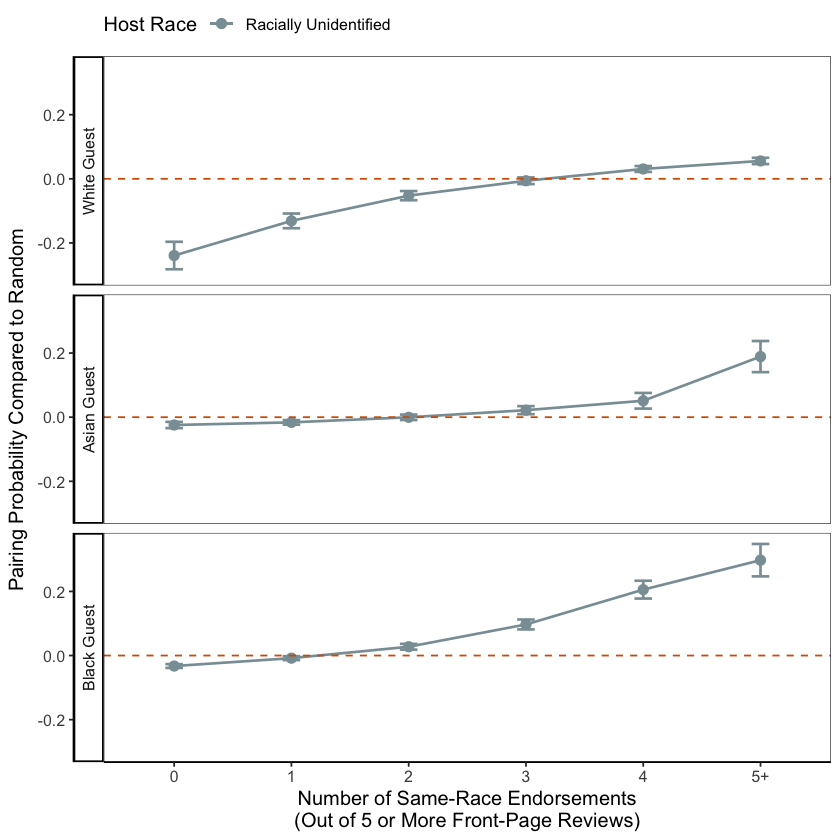

In [46]:
g

In [47]:
fig_2a=g

#### Randomly chosen (Fig. 2B)

In [48]:
tmp_obs = summary.pairing.prob.obs[summary.pairing.prob.obs$h.ethnicity!="RA",]

In [49]:
tmp_normed = summary.pairing.prob.diff[summary.pairing.prob.diff$h.ethnicity!="RA",]

In [51]:
#-Bootstrapped re-weighted mean to create standard errors... .
#-We applied the same weight for each race of guests to measure 
#-the probability of booking with a randomly chosen host of known race... .

library(boot)

samplewmean <- function(data, d) {
  return(weighted.mean(x=data[d,1], w=data[d,2]))
}

start_time=Sys.time()

l_boot_mean=list()
for (x in unique(tmp_obs$sre)) {
    for (y in unique(tmp_obs$g.ethnicity)) {
        df.tmp.obs=tmp_obs[(tmp_obs$sre==x)&
                           (tmp_obs$g.ethnicity==y),]
        l.weight=rep(1,length(df.tmp.obs$N))
        df.tmp.normed=tmp_normed[(tmp_normed$sre==x)&
                                 (tmp_obs$g.ethnicity==y),]
        l.normed.prob=df.tmp.normed$prob.diff

        boot_mean=boot(data=cbind(l.normed.prob, l.weight), 
                       statistic=samplewmean, 
                       R=1000)

        l_boot_mean[[paste("boot_mean", x, y, sep=".")]]=data.frame(matrix(c(boot_mean$t0,sd(boot_mean$t),x,y), 1))    
    }
}


end_time=Sys.time()
end_time - start_time

Time difference of 0.2627919 secs

In [52]:
tmp=do.call(rbind.data.frame, l_boot_mean)
colnames(tmp)=c("prob.diff", "sd", "sre", "g.ethnicity")
tmp$ci=as.numeric(tmp$sd)*1.96
tmp$prob.diff=as.numeric(tmp$prob.diff)
tmp$sre=as.factor(tmp$sre)
tmp$h.ethnicity="Randomly Chosen"
tmp

,prob.diff,sd,sre,g.ethnicity,ci,h.ethnicity
,<dbl>,<chr>,<fct>,<chr>,<dbl>,<chr>
boot_mean.0.ASIAN,-0.025739529,0.00235727364208689,0,ASIAN,0.004620256,Randomly Chosen
boot_mean.0.BLACK,-0.028013215,0.00685492233183443,0,BLACK,0.013435648,Randomly Chosen
boot_mean.0.WHITE,-0.193978685,0.0161594452043966,0,WHITE,0.031672513,Randomly Chosen
boot_mean.1.ASIAN,-0.007485407,0.00678641694347874,1,ASIAN,0.013301377,Randomly Chosen
boot_mean.1.BLACK,-0.008816223,0.0112821114439184,1,BLACK,0.022112938,Randomly Chosen
boot_mean.1.WHITE,-0.106991967,0.017645237743293,1,WHITE,0.034584666,Randomly Chosen
boot_mean.2.ASIAN,0.011717204,0.0103892946439606,2,ASIAN,0.020363018,Randomly Chosen
boot_mean.2.BLACK,0.018874906,0.0176558926008674,2,BLACK,0.034605549,Randomly Chosen
boot_mean.2.WHITE,-0.062219220,0.0190658951765818,2,WHITE,0.037369155,Randomly Chosen


In [53]:
tmp$g.ethnicity=factor(tmp$g.ethnicity,
                       levels=c("WHITE","ASIAN","BLACK"),
                       ordered=TRUE)

In [54]:
l_guest.race.label=c(
    "BLACK"="Black Guest",
    "WHITE"="White Guest",
    "ASIAN"="Asian Guest")
cc=c("#899da4","#f1aa00","#be5d05","#2c2d4a")

dodge=position_dodge(width=0.5)
pdf("../output/fig_2b.pdf", width=4, height=5)
g = ggplot(tmp, aes(x=sre, y=prob.diff)) + 
  geom_line(position=dodge, size=0.75, aes(color=h.ethnicity, group=h.ethnicity)) +
  xlab("Number of Same-Race Endorsements\n(Out of 5 or More Front-Page Reviews)") + 
  # ylab("Pairing Probability Compared to Random") +
  ylab("") +
  geom_point(position=dodge, aes(color=h.ethnicity, group=h.ethnicity), size=2.5) +
  geom_errorbar(aes(ymin=prob.diff-ci, ymax=prob.diff+ci, color=h.ethnicity),
                size=0.75, width=0.15, position=dodge) +
  scale_color_manual(values=cc) +
  scale_x_discrete(labels=c("0","1","2","3","4","5+")) +
  facet_grid(g.ethnicity~., margins=FALSE, switch="y", scales="free_y",
             labeller=as_labeller(l_guest.race.label)) + labs(color="Host Race") +
             theme_classic() + theme(panel.border=element_rect(fill=NA, size=0.3)) +
  coord_cartesian(ylim=c(-0.35,0.35)) +
  geom_hline(yintercept=0, linetype="dashed", color="#D55E00") +
  theme(#legend.position="none",
        legend.position="top",
        legend.justification='left',
        legend.margin=margin(0, unit="cm"),
        legend.spacing.y=unit(0, unit="cm"),
        panel.grid.major=element_blank(),
        text=element_text(size=12))
plot(g)
dev.off()

pdf 
  2

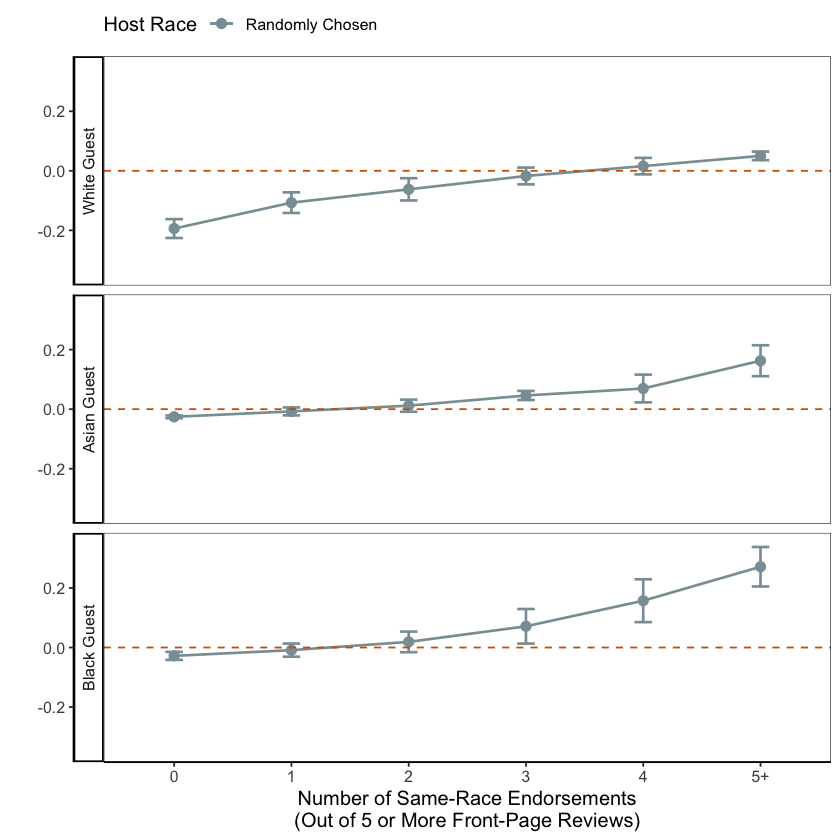

In [55]:
g

In [56]:
fig_2b=g

### 4. Compile Figs. 2A and 2B

In [57]:
library(cowplot)

g <- plot_grid(fig_2a,fig_2b,
               align="h",
               labels="AUTO", label_size=12,
               ncol=2)

In [59]:
pdf(file="../output/fig_2.pdf", width=9, height=5)
print(g)
dev.off()

pdf 
  2